In [74]:
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load data and make sure we have 70 unique patients

In [75]:
df = pd.read_csv('hadrup_cancer_df_29K_csv.csv')
len(df['patient'].unique())

70

# Input ImmunoStruct_predicted labels as a new column, for the respective pMHCs under df['combo']

In [76]:
df = pd.read_csv('hadrup_cancer_df_29K_csv.csv')


# Define your custom mappings
mapping = {
    'mUC': 'BC',
    'MM': 'Neye',
    'RH': 'RH'
    # You can add more mappings here if needed
}

# Function to convert patient codes
def convert_patient_code(patient):
    prefix, number = patient.split('-')
    if prefix in mapping:
        return f"{mapping[prefix]}-{number}"
    else:
        return patient  # Keep it unchanged if no mapping

# Assuming your dataframe is named df
df['patient_ID'] = df['patient'].apply(convert_patient_code)


#This is where to insert the predicted labels for each pMHC sample. I set it all to 1's for now since we don't yet have the predictions/
#and we are still optimizing the cancer model 

df['ImmunoStruct_predicted'] = 1

df

,mut_peptide,allele,combo,patient,hla_seq,immunogenicity,patient_ID,ImmunoStruct_predicted
0,YTDQISKYA,HLA-A01:01,YTDQISKYAHLA-A01:01,mUC-1849,SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEP...,1,BC-1849,1
1,QLEQLMQLY,HLA-A01:01,QLEQLMQLYHLA-A01:01,mUC-1849,SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEP...,1,BC-1849,1
2,ILEYTDQISKY,HLA-A01:01,ILEYTDQISKYHLA-A01:01,mUC-1849,SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEP...,1,BC-1849,1
3,VTSEVSNLK,HLA-A11:01,VTSEVSNLKHLA-A11:01,mUC-1849,SHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEP...,1,BC-1849,1
4,SSEPPFGPK,HLA-A11:01,SSEPPFGPKHLA-A11:01,mUC-1849,SHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEP...,1,BC-1849,1
...,...,...,...,...,...,...,...,...
29479,SMSSIWGTMF,HLA-B15:01,SMSSIWGTMFHLA-B15:01,RH-17,SHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAP...,3,RH-17,1
29480,QTLWPILAL,HLA-B07:02,QTLWPILALHLA-B07:02,RH-17,SHSMRYFYTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPREEP...,3,RH-17,1
29481,ALISMSSIW,HLA-B15:01,ALISMSSIWHLA-B15:01,RH-17,SHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRMAP...,3,RH-17,1
29482,QTLWPILALI,HLA-A02:01,QTLWPILALIHLA-A02:01,RH-17,SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEP...,3,RH-17,1


# Count up all the pMHCs that were predicted to be immunogenic, grouped by patient

In [77]:


# Assuming df is your dataframe

# Step 1: Aggregate ImmunoStruct_predicted by patient_ID to create ImmunoStruct_predicted_load
# For example, summing the predicted scores for each patient
immunostruct_load_df = df.groupby('patient_ID')['ImmunoStruct_predicted'].sum().reset_index()
immunostruct_load_df = immunostruct_load_df.sort_values('patient_ID')
immunostruct_load_df

,patient_ID,ImmunoStruct_predicted
0,BC-1233,85
1,BC-1249,498
2,BC-1849,299
3,BC-1994,133
4,BC-2131,742
...,...,...
65,RH-30,81
66,RH-31,1027
67,RH-33,616
68,RH-34,31


# Merge with the clinical survival data

In [78]:
clin_df = pd.read_table('All_samples_clinical.txt')



# Replace commas with decimal points in the PFS.Time and OS.Time columns
clin_df['PFS.Time'] = clin_df['PFS.Time'].astype(str).str.replace(',', '.')
clin_df['OS.Time'] = clin_df['OS.Time'].astype(str).str.replace(',', '.')

# Optionally, convert the columns back to floats
clin_df['PFS.Time'] = clin_df['PFS.Time'].astype(float)
clin_df['OS.Time'] = clin_df['OS.Time'].astype(float)


clin_df['patient_ID'] = clin_df['Patient']
clin_df = clin_df.sort_values('patient_ID')

# Step 2: Merge this new ImmunoStruct_predicted_load back into the main clinical dataframe
#clin_df = clin_df.merge(immunostruct_load_df, on='patient_ID', how='left')
clin_df['ImmunoStruct_predicted_load'] = immunostruct_load_df['ImmunoStruct_predicted'].tolist()
# Step 3: Now you can compare ImmunoStruct_predicted_load to mut_load in your survival analysis
clin_df

,Patient,RECIST,PFS.Time,OS.Time,PFS.Event,OS.Event,mut_load,patient_ID,ImmunoStruct_predicted_load
23,BC-1233,PR,40.115847,64.954159,1,0,108,BC-1233,85
3,BC-1249,PD,1.347051,1.774165,1,1,583,BC-1249,498
16,BC-1849,SD,8.706551,15.376098,1,1,697,BC-1849,299
5,BC-1994,SD,3.975444,13.240529,1,1,104,BC-1994,133
21,BC-2131,CR,64.559901,64.559901,0,0,2230,BC-2131,742
...,...,...,...,...,...,...,...,...,...
66,RH-30,PD,2.037004,3.219781,1,0,106,RH-30,81
67,RH-31,PD,2.661248,0.525679,1,1,1360,RH-31,1027
68,RH-33,PD,1.741310,4.731107,1,1,722,RH-33,616
69,RH-34,SD,3.909734,3.909734,0,0,100,RH-34,31


# Here is where we finally compute the p-values for overall survival and progression-free survival (e.g., a lower p-value means ImmunoStruct did a better job predicting survival based on pMHC predicted immunogenicity) 

In [79]:
import pandas as pd
from lifelines.statistics import logrank_test

# Assuming clin_df is the dataframe that includes the ImmunoStruct_predicted_load column

# Step 1: Define a threshold to split ImmunoStruct_predicted_load into low and high groups
immuno_struct_threshold = clin_df['ImmunoStruct_predicted_load'].median()
low_immuno_struct = clin_df[clin_df['ImmunoStruct_predicted_load'] <= immuno_struct_threshold]
high_immuno_struct = clin_df[clin_df['ImmunoStruct_predicted_load'] > immuno_struct_threshold]

# Step 2: Perform the log-rank test for OS
result_os = logrank_test(low_immuno_struct['OS.Time'], high_immuno_struct['OS.Time'], 
                         event_observed_A=low_immuno_struct['OS.Event'], 
                         event_observed_B=high_immuno_struct['OS.Event'])

# Get the OS p-value
os_p_value = result_os.p_value

# Step 3: Perform the log-rank test for PFS
result_pfs = logrank_test(low_immuno_struct['PFS.Time'], high_immuno_struct['PFS.Time'], 
                          event_observed_A=low_immuno_struct['PFS.Event'], 
                          event_observed_B=high_immuno_struct['PFS.Event'])

# Get the PFS p-value
pfs_p_value = result_pfs.p_value

# Output the p-values
print(f'OS p-value: {os_p_value:.4f}')
print(f'PFS p-value: {pfs_p_value:.4f}')


OS p-value: 0.1428
PFS p-value: 0.0513


# Some plotting code to visualize the groups' survivals (just switch out "mut_load" with "ImmunoStruct_predicted_load" to see how our model is doing)

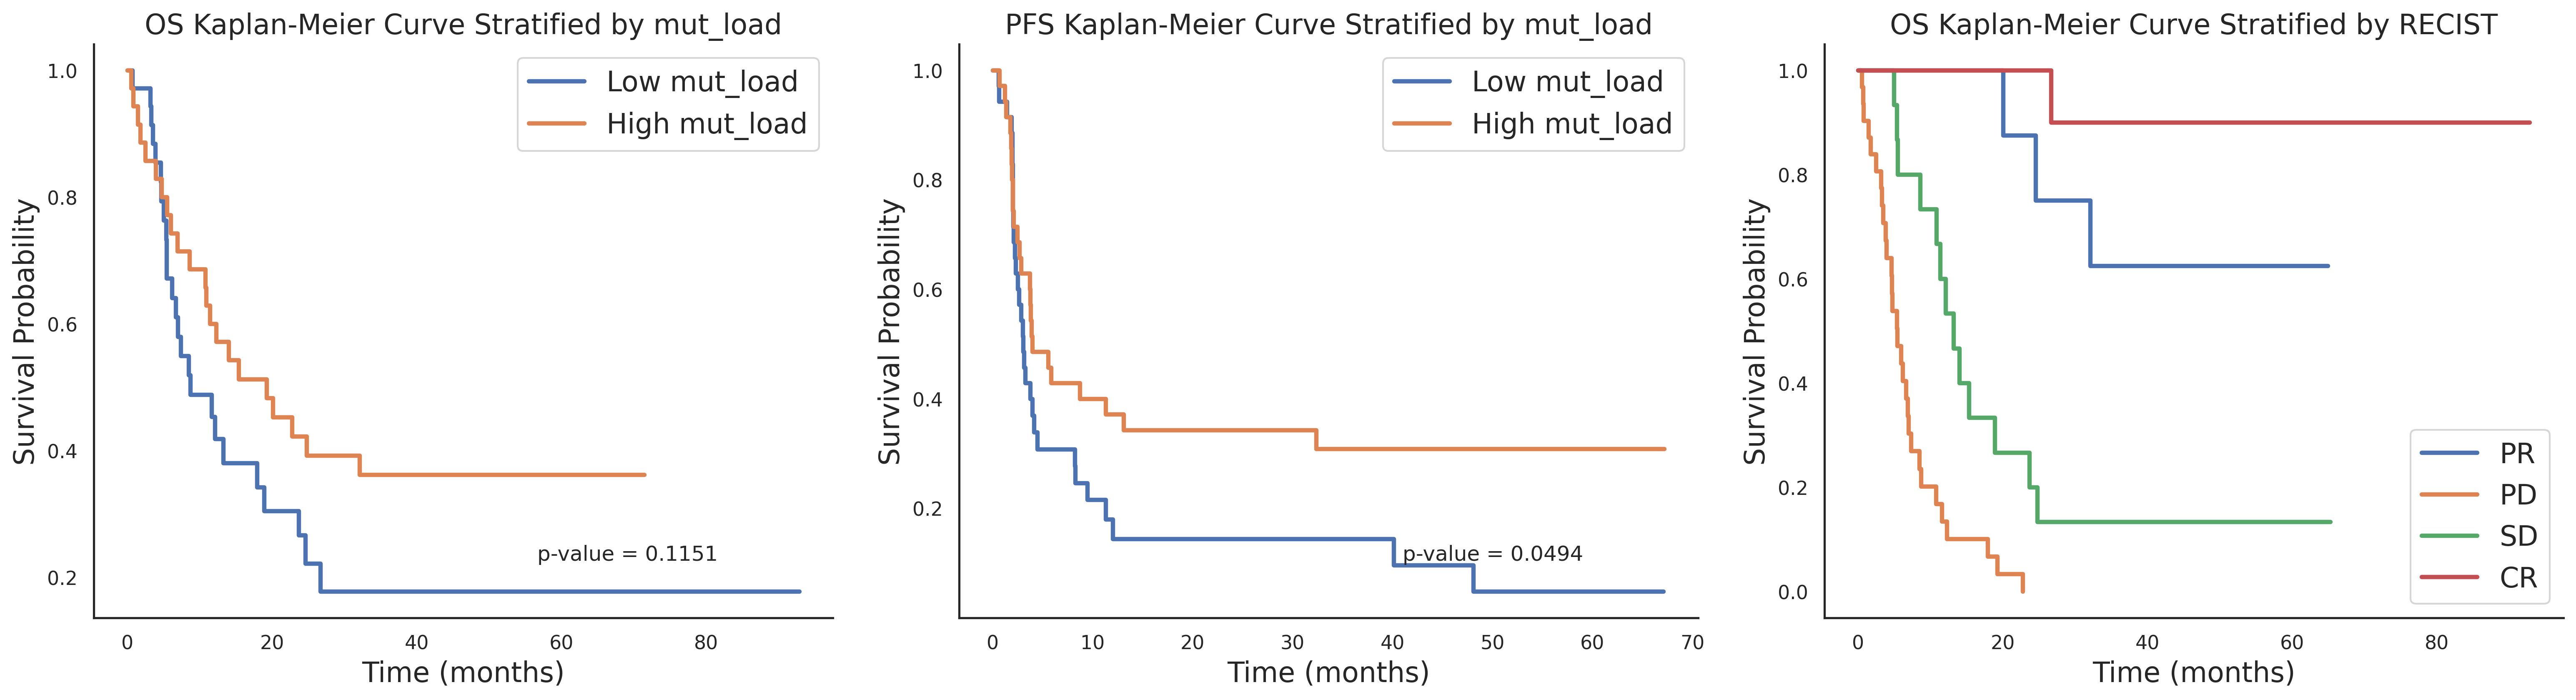

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Set Seaborn style
sns.set(style="white")

# Set the font size globally using rcParams
plt.rcParams.update({'font.size': 20})

# Assuming clin_df is your dataframe

# Create three subplots: OS, PFS, and RECIST
fig, axes = plt.subplots(1, 3, figsize=(21, 6), dpi=300)

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# 1st plot: Stratifying OS by 'mut_load'
mut_load_threshold = clin_df['mut_load'].median()
low_mut_load = clin_df[clin_df['mut_load'] <= mut_load_threshold]
high_mut_load = clin_df[clin_df['mut_load'] > mut_load_threshold]

# Fit and plot for low mutational load (OS)
kmf.fit(low_mut_load['OS.Time'], event_observed=low_mut_load['OS.Event'], label='Low mut_load')
kmf.plot_survival_function(ax=axes[0], ci_show=False, linewidth=2.5)

# Fit and plot for high mutational load (OS)
kmf.fit(high_mut_load['OS.Time'], event_observed=high_mut_load['OS.Event'], label='High mut_load')
kmf.plot_survival_function(ax=axes[0], ci_show=False, linewidth=2.5)

# Perform log-rank test for OS
result = logrank_test(low_mut_load['OS.Time'], high_mut_load['OS.Time'], 
                      event_observed_A=low_mut_load['OS.Event'], event_observed_B=high_mut_load['OS.Event'])
p_value = result.p_value

# Add p-value annotation for OS plot
axes[0].text(0.6, 0.1, f'p-value = {p_value:.4f}', transform=axes[0].transAxes, fontsize=12)

# Set title and labels for OS plot
axes[0].set_title('OS Kaplan-Meier Curve Stratified by mut_load', fontsize=16)
axes[0].set_xlabel('Time (months)', fontsize=16)
axes[0].set_ylabel('Survival Probability', fontsize=16)

# 2nd plot: Stratifying PFS by 'mut_load'
# Fit and plot for low mutational load (PFS)
kmf.fit(low_mut_load['PFS.Time'], event_observed=low_mut_load['PFS.Event'], label='Low mut_load')
kmf.plot_survival_function(ax=axes[1], ci_show=False, linewidth=2.5)

# Fit and plot for high mutational load (PFS)
kmf.fit(high_mut_load['PFS.Time'], event_observed=high_mut_load['PFS.Event'], label='High mut_load')
kmf.plot_survival_function(ax=axes[1], ci_show=False, linewidth=2.5)

# Perform log-rank test for PFS
result_pfs = logrank_test(low_mut_load['PFS.Time'], high_mut_load['PFS.Time'], 
                          event_observed_A=low_mut_load['PFS.Event'], event_observed_B=high_mut_load['PFS.Event'])
p_value_pfs = result_pfs.p_value

# Add p-value annotation for PFS plot
axes[1].text(0.6, 0.1, f'p-value = {p_value_pfs:.4f}', transform=axes[1].transAxes, fontsize=12)

# Set title and labels for PFS plot
axes[1].set_title('PFS Kaplan-Meier Curve Stratified by mut_load', fontsize=16)
axes[1].set_xlabel('Time (months)', fontsize=16)
axes[1].set_ylabel('Survival Probability', fontsize=16)

# 3rd plot: Stratifying by 'RECIST'
for recist_type in clin_df['RECIST'].unique():
    group = clin_df[clin_df['RECIST'] == recist_type]
    kmf.fit(group['OS.Time'], event_observed=group['OS.Event'], label=recist_type)
    kmf.plot_survival_function(ax=axes[2], ci_show=False, linewidth=2.5)

# Set title and labels for RECIST plot
axes[2].set_title('OS Kaplan-Meier Curve Stratified by RECIST', fontsize=16)
axes[2].set_xlabel('Time (months)', fontsize=16)
axes[2].set_ylabel('Survival Probability', fontsize=16)

# Apply Seaborn styling to the overall plot
sns.despine()

# Increase font sizes of the legends
axes[0].legend(fontsize=16)
axes[1].legend(fontsize=16)
axes[2].legend(fontsize=16)

# Display the plots
plt.tight_layout()
plt.show()
